##掛載雲端硬碟


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##更改檔案所在路徑

In [2]:
# Change to your own folder !!!
%cd /content/drive/MyDrive/EAI_Lab4_2024

/content/drive/MyDrive/EAI_Lab4_2024


## Import library

In [3]:
from __future__ import print_function
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models import vgg

## 設定超參數(填空)

In [4]:
SPARSITY_REGULARIZATION = True
#### 設定λ(balance factor) ####
################################################
#          請填空          #
################################################
LAMBDA =0.001

SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 60
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LOG_INTERVAL = 100
CUDA = True

RESUME = False
START_EPOCH = 0

WEIGHT_PATH = '/content/drive/MyDrive/Colab Notebooks/model_best.pth'


In [5]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


##下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [6]:
#### 資料集 ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

Files already downloaded and verified


## 定義模型與載入訓練好的權重

In [7]:
model = vgg()
if CUDA:
    model.cuda()

##設定Optimizer，這裡使用Stocastic Gradient Descent

In [8]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

##使用論文中稀疏化的方式更新參數(填空)

In [9]:
def updateBN():
  for m in model.modules():
      if isinstance(m, nn.BatchNorm2d):
          #### 完成Sparsity Regularization ####
          ################################################
          m.weight.grad.data.add_(LAMBDA * torch.sign(m.weight.data))
          ################################################






## 載入預先定義好的模型與參數

In [10]:
if(RESUME):
  checkpoint = torch.load(WEIGHT_PATH)
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  START_EPOCH = checkpoint['epoch']
  best_prec1 = checkpoint['best_prec1']
  print(f'RESUME MODEL @EPOCH={START_EPOCH}, BEST_PREC1={best_prec1}')

## 定義訓練跟測試函數

In [11]:
#### 訓練函數 #####
# 新增變數來記錄每個 epoch 的訓練和測試精度
train_accuracies = []
test_accuracies = []


# 注意: 需自行撰寫儲存每個epoch之train acc的code，以便後續繪製train acc結果圖!
def train(epoch):
    model.train()
    correct = 0  # 用來計算訓練精度
    total = 0    # 紀錄總數

    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()

        if SPARSITY_REGULARIZATION:
            updateBN()
        optimizer.step()

        # 計算訓練精度
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        total += target.size(0)

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

    # 計算並記錄當前 epoch 的訓練精度
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch}, Train Accuracy: {train_accuracy:.4f}')

#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            if CUDA:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').data.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / float(len(test_loader.dataset))
    test_accuracies.append(test_accuracy)  # 記錄測試精度
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * test_accuracy))
    return test_accuracy

best_prec1 = 0.
for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本1/10
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()

    # 儲存模型權重，方便做後續剪枝,後續訓練
    if(prec1 > best_prec1):
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, WEIGHT_PATH)

    best_prec1 = max(prec1, best_prec1)


Train Epoch: 0 [0/50000 (0.0%)]	Loss: 2.304169
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 1.823476
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 1.504560
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 1.447149
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 1.166944
Epoch 0, Train Accuracy: 0.4309

Test set: Average loss: 1.6974, Accuracy: 4291/10000 (42.9%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 1.309176
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 1.069333
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 1.062895
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 1.129283
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 1.189605
Epoch 1, Train Accuracy: 0.5785

Test set: Average loss: 2.1785, Accuracy: 3372/10000 (33.7%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 1.348280
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.874569
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 1.032203
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 1.194120
Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 1.050684
Epoch 2, Train Accuracy: 0.6349

Test set: Av

##繪製Sparsity-Training結果圖

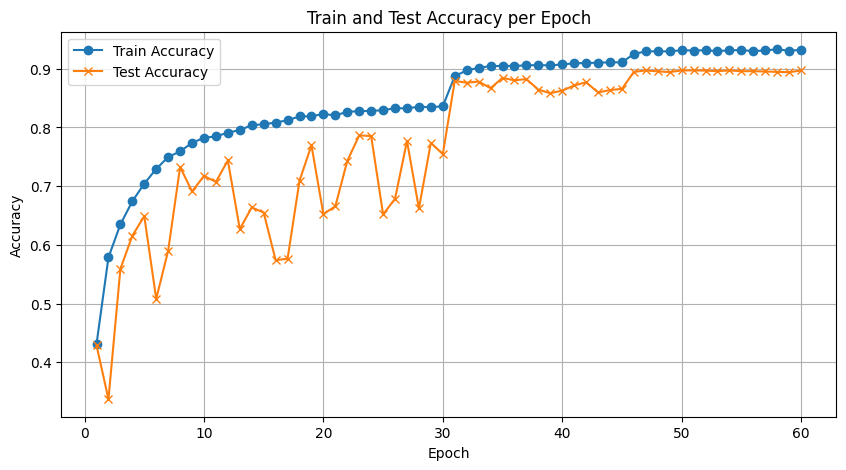

In [12]:
import matplotlib.pyplot as plt

# 訓練結束後繪製曲線
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(10, 5))

# 繪製訓練精度
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')

# 繪製測試精度
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='x')

# 標註
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()


## 繪製scaling factor 分布圖

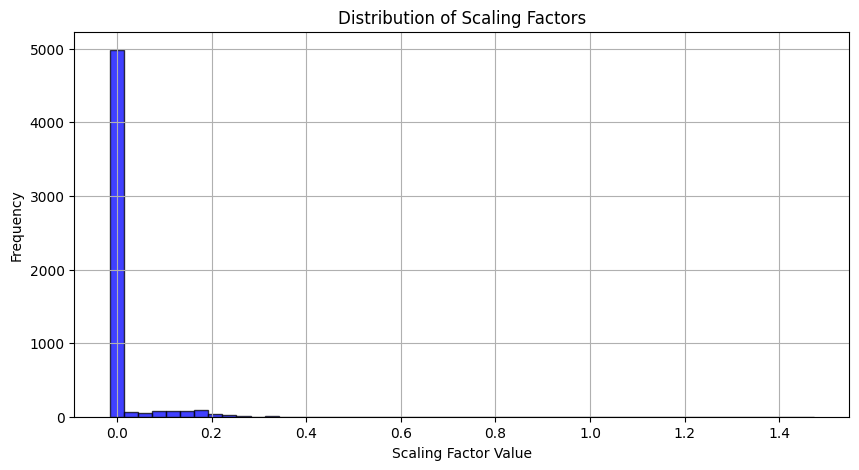

In [13]:
#繪製 scaling factor 分布圖
#繪製 scaling factor 分布圖
import matplotlib.pyplot as plt

def plot_scaling_factor_distribution(model):
    scaling_factors = []

    # 遍歷模型的所有層，提取 BatchNorm 層的縮放因子 (weight)
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            scaling_factors.extend(m.weight.data.cpu().numpy())  # 將縮放因子加到列表中

    # 繪製直方圖顯示 scaling factor 的分布
    plt.figure(figsize=(10, 5))
    plt.hist(scaling_factors, bins=50, alpha=0.75, color='b', edgecolor='black')
    plt.xlabel('Scaling Factor Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Scaling Factors')
    plt.grid(True)
    plt.show()

# 調用函數來繪製 scaling factor 分布圖
plot_scaling_factor_distribution(model)
